In [13]:
# ===============================
# 📦 Step 1: Load & Preprocess
# ===============================

import pandas as pd

# Load dataset
df = pd.read_csv("traffic_dataset.csv")

# Only use the first 20,000 rows
df = df.iloc[:22000]

# Clean inconsistent attack category labels
df['Attack category'] = df['Attack category'].str.strip()  # remove leading/trailing spaces
label_mapping = {
    "Backdoors": "Backdoor",
    "Shellcode ": "Shellcode",  # with trailing space
    "Fuzzers ": "Fuzzers",
    "Reconnaissance ": "Reconnaissance"
}
df['Attack category'] = df['Attack category'].replace(label_mapping)

# Convert timestamps
df['Start time'] = pd.to_datetime(df['Start time'], unit='s')
df['Last time'] = pd.to_datetime(df['Last time'], unit='s')

# Fill missing values
df.fillna("Unknown", inplace=True)

# Encode categorical features
df['Protocol'] = df['Protocol'].astype('category').cat.codes
df['Attack category'] = df['Attack category'].astype('category')
df['Attack subcategory'] = df['Attack subcategory'].astype('category').cat.codes

# Save label decoder for future use
attack_category_decoder = dict(enumerate(df['Attack category'].cat.categories))

# Convert to numeric
df['Attack category'] = df['Attack category'].cat.codes

# Step 5: Print the mapping
print("🧩 Correct Label ID → Attack Category mapping:\n")
for k, v in attack_category_decoder.items():
    print(f"{k}: {v}")
    
# Create traffic text
df['traffic_text'] = df.apply(lambda row:
    f"Protocol: {row['Protocol']}, Source: {row['Source IP']}:{row['Source Port']}, "
    f"Destination: {row['Destination IP']}:{row['Destination Port']}, "
    f"Attack Name: {row['Attack Name']}", axis=1)
    # f"Attack Name: {row['Attack Name']}, Subcategory: {row['Attack subcategory']}", axis=1)

print("✅ Preprocessing completed.")

# ===============================
# ✂️ Step 2: Tokenization & Embedding
# ===============================

from transformers import AutoTokenizer, AutoModel
import torch
import gc

model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to('cpu')
model.eval()

mini_batch_size = 256
all_embeddings = []

for i in range(0, len(df), mini_batch_size):
    print(f"Embedding batch: {i} to {i + mini_batch_size}")
    sub_texts = df['traffic_text'].iloc[i:i + mini_batch_size].tolist()

    tokens = tokenizer(sub_texts, padding=True, truncation=True, max_length=512, return_tensors="pt").to('cpu')

    with torch.no_grad():
        outputs = model(**tokens)
        embeddings = outputs.last_hidden_state.mean(dim=1)
        all_embeddings.append(embeddings)

    del tokens, outputs, embeddings
    gc.collect()
    torch.cuda.empty_cache()

print("✅ All mini-batch embeddings done.")

final_embeddings = torch.cat(all_embeddings, dim=0)
print(f"Final embedding shape: {final_embeddings.shape}")

🧩 Correct Label ID → Attack Category mapping:

0: Analysis
1: Backdoor
2: DoS
3: Exploits
4: Fuzzers
5: Generic
6: Reconnaissance
7: Shellcode
8: Worms
✅ Preprocessing completed.
Embedding batch: 0 to 256
Embedding batch: 256 to 512
Embedding batch: 512 to 768
Embedding batch: 768 to 1024
Embedding batch: 1024 to 1280
Embedding batch: 1280 to 1536
Embedding batch: 1536 to 1792
Embedding batch: 1792 to 2048
Embedding batch: 2048 to 2304
Embedding batch: 2304 to 2560
Embedding batch: 2560 to 2816
Embedding batch: 2816 to 3072
Embedding batch: 3072 to 3328
Embedding batch: 3328 to 3584
Embedding batch: 3584 to 3840
Embedding batch: 3840 to 4096
Embedding batch: 4096 to 4352
Embedding batch: 4352 to 4608
Embedding batch: 4608 to 4864
Embedding batch: 4864 to 5120
Embedding batch: 5120 to 5376
Embedding batch: 5376 to 5632
Embedding batch: 5632 to 5888
Embedding batch: 5888 to 6144
Embedding batch: 6144 to 6400
Embedding batch: 6400 to 6656
Embedding batch: 6656 to 6912
Embedding batch: 691

In [5]:
!pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


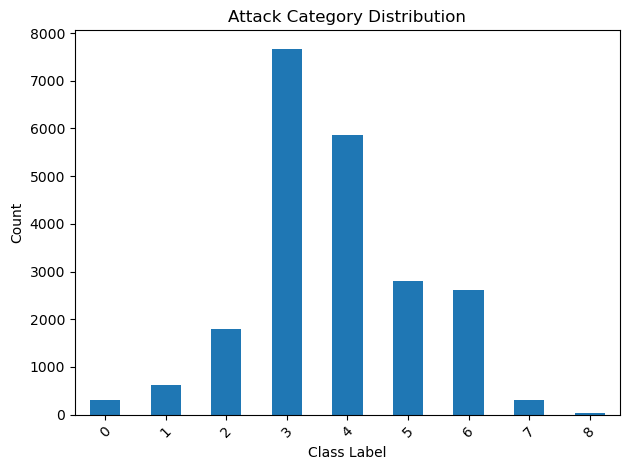

In [14]:
# for running without SMOTE
import matplotlib.pyplot as plt

df['Attack category'].value_counts().sort_index().plot(
    kind='bar', title="Attack Category Distribution", rot=45
)
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Original training set size: 17600
Resampled training set size: 55260

✅ Model Evaluation (Balanced Training):
Accuracy: 0.9752272727272727

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      0.95      0.97       123
           2       0.94      0.83      0.88       357
           3       0.95      0.99      0.97      1535
           4       1.00      1.00      1.00      1173
           5       1.00      0.98      0.99       559
           6       1.00      0.99      0.99       524
           7       1.00      0.97      0.98        59
           8       1.00      0.86      0.92         7

    accuracy                           0.98      4400
   macro avg       0.99      0.95      0.97      4400
weighted avg       0.98      0.98      0.97      4400

💾 Model saved as 'attack_classifier_balanced.pkl'


C:\Users\suche\AppData\Local\Temp\ipykernel_22144\4282309925.py:71: UserWarning: Glyph 129518 (\N{ABACUS}) missing from current font.
  plt.tight_layout()
C:\Users\suche\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


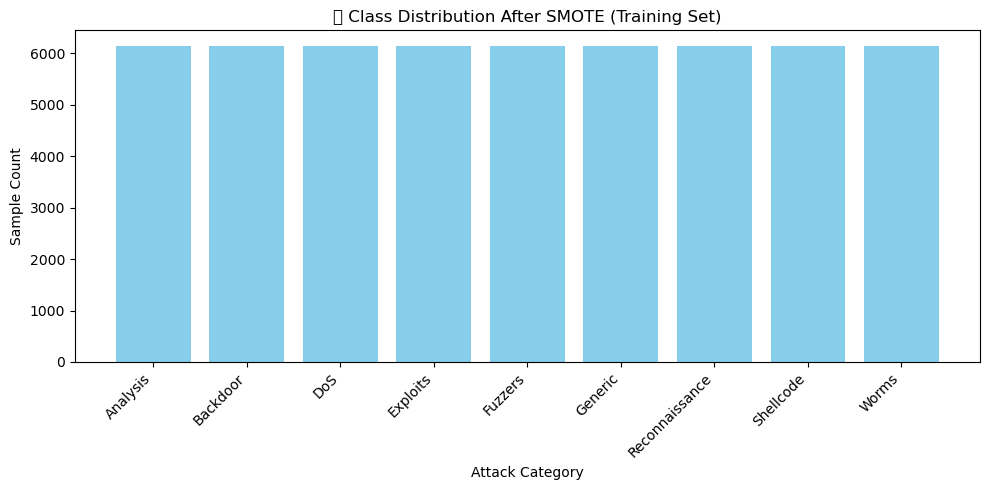

In [15]:
# ===============================
# 🎯 Step 3: Train Classifier (Balanced with SMOTE)
# ===============================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import joblib
import numpy as np

# Features and Labels
X = final_embeddings.numpy()
y = df['Attack category'].values

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# =========================
# 🚀 Apply SMOTE on Training Set Only
# =========================
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original training set size:", X_train.shape[0])
print("Resampled training set size:", X_train_resampled.shape[0])

# =========================
# 🤖 Train Classifier
# =========================
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# =========================
# 🧪 Evaluation
# =========================
y_pred = clf.predict(X_test)

print("\n✅ Model Evaluation (Balanced Training):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# =========================
# 💾 Save Model
# =========================
joblib.dump(clf, "attack_classifier_balanced.pkl")
print("💾 Model saved as 'attack_classifier_balanced.pkl'")


import pandas as pd
import matplotlib.pyplot as plt

# Convert y_train_resampled to a pandas Series
y_resampled_series = pd.Series(y_train_resampled)

# Count each class
class_counts = y_resampled_series.value_counts().sort_index()

# If you have a decoder (label ID → attack category name), use it for clearer labels
if 'attack_category_decoder' in globals():
    labels = [attack_category_decoder[i] for i in class_counts.index]
else:
    labels = class_counts.index.astype(str)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(labels, class_counts.values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Attack Category")
plt.ylabel("Sample Count")
plt.title("🧮 Class Distribution After SMOTE (Training Set)")
plt.tight_layout()
plt.show()


In [25]:
##### import torch
from transformers import AutoTokenizer, AutoModel
import joblib

# Load trained classifier
clf = joblib.load("attack_classifier_balanced.pkl")

# Load tokenizer and BERT model
model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name).to("cpu")
bert_model.eval()

# 🧾 Sample input from your dataset 
# sample_text = ["Protocol: tcp, Source: 175.45.176.0:13284, Destination: 149.171.126.16:80, Attack Name: Domino Web Server Database Access: /doladmin.nsf (https://strikecenter.bpointsys.com/bps/strikes/recon/http/domino/access_domino_doladmin_nsf.xml)"]
# sample_text = ["Protocol: udp, Source: 175.45.176.3:21223, Destination: 149.171.126.18:32780, Attack Name: Solaris rwalld Format String Vulnerability (https://strikecenter.bpointsys.com/bps/strikes/exploits/rservices/solaris_rwall_format_string.xml)"]
# sample_text = ["Protocol: tcp, Source: 175.45.176.0:39500, Destination: 149.171.126.15:80, Attack Name: Cisco DCP2100 SADownStartingFrequency Denial of Service (https://strikecenter.bpointsys.com/bps/strikes/denial/misc/cisco_dcp2100_denial_of_service.xml)"]
# sample_text = ["Protocol: tcp, Source: 175.45.176.0:29309, Destination: 149.171.126.14:3000, Attack Name: Alt-N_MDaemon_WorldClient_Service_Memory_Corruption_attack (https://strikecenter.bpointsys.com/bps/strikes/generic/ixia/alt-n_mdaemon_worldclient_service_memory_corruption_attack.xml)"]
# sample_text = ["Protocol: tcp, Source: 175.45.176.0:3925, Destination: 149.171.126.16:445, Attack Name: Fuzzer: SMB Session Setup Invalid Native Lan Manager (NTLMv1) (https://strikecenter.bpointsys.com/bps/strikes/fuzzers/smb/session_setup_ntlmv1_invalid_lanman.xml)"]

# Convert to embeddings
tokens = tokenizer(sample_text, padding=True, truncation=True, return_tensors="pt").to("cpu")
with torch.no_grad():
    embeddings = bert_model(**tokens).last_hidden_state.mean(dim=1).numpy()

# Make prediction
prediction = clf.predict(embeddings)

# 🔁 Use your attack category decoder
attack_category_decoder = {
    0: "Analysis",
    1: "Backdoor",
    2: "DoS",
    3: "Exploits",
    4: "Fuzzers",
    5: "Generic",
    6: "Reconnaissance",
    7: "Shellcode",
    8: "Worms"
}

# Output
print("Predicted Class Label:", prediction[0])
print("Predicted Attack Category:", attack_category_decoder[prediction[0]])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predicted Class Label: 4
Predicted Attack Category: Fuzzers


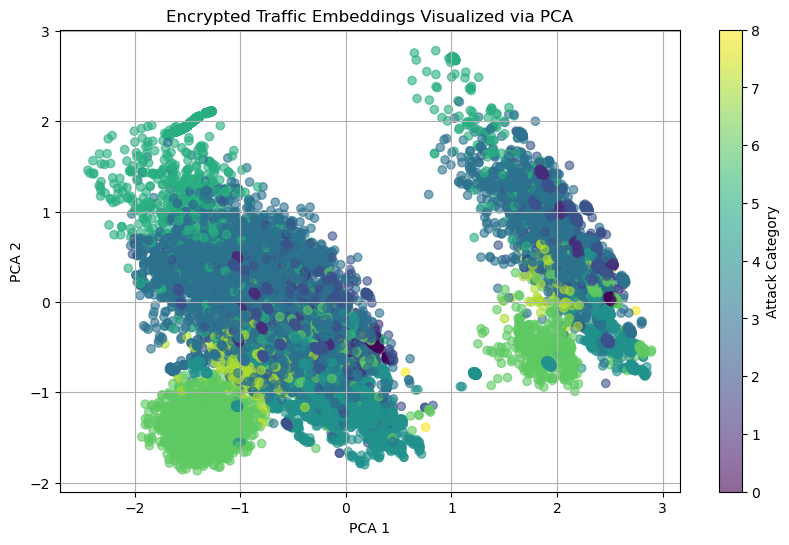

In [17]:
# ===============================
# 🌍 Step 4: Visualize Embeddings
# ===============================

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.title("Encrypted Traffic Embeddings Visualized via PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Attack Category')
plt.grid(True)
plt.show()

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np


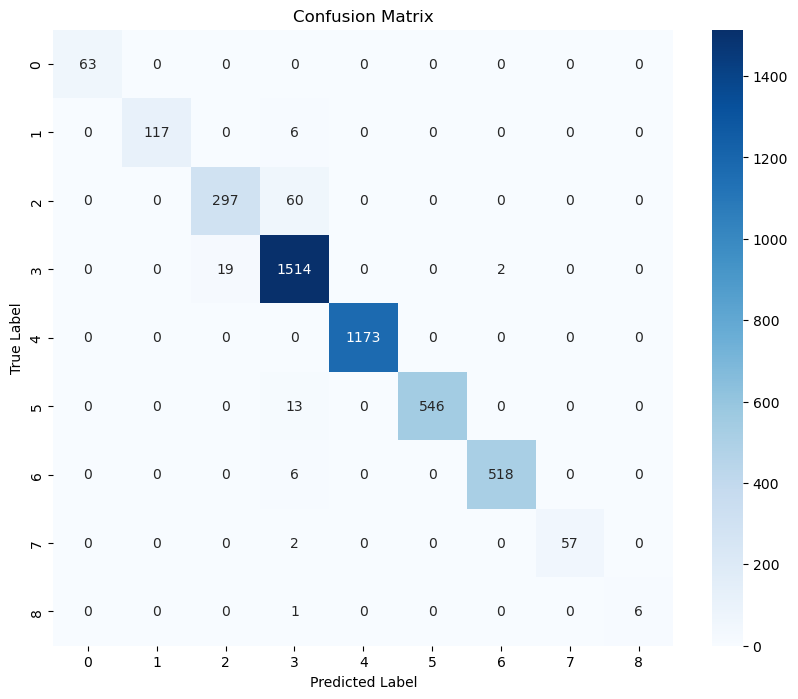

In [29]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


C:\Users\suche\AppData\Local\Temp\ipykernel_22144\2447973134.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


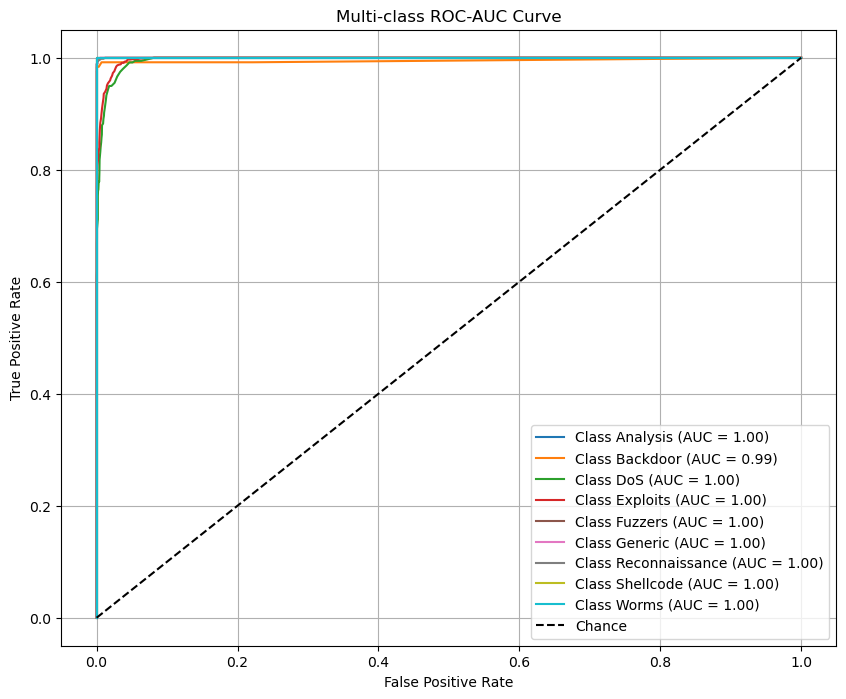

In [31]:
# Binarize the output for ROC
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
y_pred_prob = clf.predict_proba(X_test)  # Only works if your classifier supports predict_proba

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {attack_category_decoder[i]} (AUC = {roc_auc[i]:.2f})", color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC-AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [18]:
# ===============================
# 🔐 Step 5: Save Outputs
# ===============================

import joblib

np.save("bert_embeddings_25.npy", X)
joblib.dump(clf, "attack_classifier_25.pkl")
joblib.dump(attack_category_decoder, "attack_category_decoder25.pkl")
df.to_csv("traffic_processed_25.csv", index=False)

print("✅ All files saved for future use.")

# model.save_pretrained("tiny_bert_suchetmodelsave25")
# tokenizer.save_pretrained("tiny_bert_suchetmodelsave25")

✅ All files saved for future use.


In [153]:
!pip install pyngrok flask torch joblib

In [155]:
!ngrok authtoken 2vS1CI8GKxtpu6HaRoqKEqf31y1_638BG6RckyfWzQ7ehgeUb

Authtoken saved to configuration file: C:\Users\suche\AppData\Local/ngrok/ngrok.yml


In [41]:
pip install streamlit transformers numpy requests